In [1]:
from pylab import *
import Fluid_CP as FCP #calculation of  thermodynamic states
import pandas as pa
import matplotlib.pyplot as plt
import Compressor_model as CM
from scipy.optimize import  minimize,NonlinearConstraint #optimization
from scipy.integrate import odeint
import plotDiag_Th_Ts as Diag
import math
import matplotlib.patheffects as path_effects

import seaborn as sns #used for camparison plots

# Heat Pump Design
In this part of the code the heat pump process is designed and its parameters are elaborated on.

Task: Design heat pump process to meet the requirements of the pasta cooker and as a function of the refirgerant and compressor diamter.

Target: Find heat pump cycle optimized for COP for different refrigerants and compressor diameters.

Requirements: Consider technical constraints, Find maximum heat transder area, Consider spacial limits.

In [3]:
#Conditions and Parameters of Heat Pump

T_so = 20.0 #fixed

Eh = "CBar"
fluid_si = 'water'
min_pinch_co = 5.0 # [K]
min_pinch_ev = 5.0 # [K]

# Set-up
refrigerants = np.array(['Isobutane', 'Butane', 'Isobutene', 'DimethylEther'])
all_dia_comp = np.array([35,40,45,50])



# COP Calculation
calc_COP calculates the COP of the heat pump, as stated by its name. The process parameters are passed to calculate the cycle states 1-4. In the end the inverse of the COP is returned as the function minimize in the optimzer searches for the minimum, thus finding a maximum COP.

In [4]:
# function to calculate the COP for the inout of T_co,T_ev, delta_T_sc, delta_T_sh during optimization

def calc_COP(param):
    T_co,T_ev, delta_T_sc, delta_T_sh=param

    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat


    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)

    param = [T_ev, T_co, delta_T_sh, delta_T_sc, dia_comp]
    efficiency = CM.recip_comp_SP(param, fluid)[0]
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/efficiency
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)

    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)

    q_high=state2["h"]-state3["h"] # [kJ/kg] spec. heat released in the condenser
    w_comp=state2["h"]-state1["h"] # [kJ/kg] #spec. compressor work 
    COP=q_high/w_comp # coefficient of performance
    
    #return reciprocal value of COP   
    return 1./COP

# Heat Exchanger
In the following the heat transfer coefficients and maximal possible length of the heat exchanger are calculated. The heat transfer coefficients are calculated using convection and heat conduction resistances per length. To maximize the condenser length of the water basin, the entire floor, as well as the walls and the areas between the pasta containers, were lined with a single layer of pipe.

In [ ]:
# Heat Conductivity in Tube
lambdas = np.array([15, 160, 200]) # [W/mK] 1.4301, Alu 3004, Kupfer Albromet-W200
lam = lambdas[0] # set desired tube material

# Dimensions of tube
do = 6.35 * 0.001 # [m] outer diameter of condenser tube in water basin
t = 0.8 * 0.001 # [m] thickness of tube
di = do - 2 * t # [m] inner diameter
A = np.power((di/2),2) * np.pi

# Transfer Coefficients
# Condenser has three sections: Vapor / 2-phase / liquid; for each the length of the piping is calculated
alpha_i = np.array([200., 2000., 1000.]) # [W/m²K]
alpha_o = 1000 # [W/m²K]

# Heat Flux Resistances
Ri_ = 1/(alpha_i*di*np.pi)
Rm_ = np.log(do/di)/(2*np.pi*lam)
Ra_ = 1/(alpha_o*do*np.pi)
R_tot_ = Ri_ + Rm_ + Ra_ # [K/W] * L[m] total resist. per m, Vector containing 3 stages


# Positioning of Pipes in Water Basin
floor_width = 0.25 # [m]
floor_length = 0.45 # [m]
basin_hight = 0.15 # [m] useful height of wall for piping
d_spacing = round(1.5 * do,4) # [m] distance between axis of neighboring tubes

# Floor
n_floor_1 = math.floor((floor_width/d_spacing)) # number of pipes on the floor of basin
n_floor_levels = 1 # one whole "layer" of piping on the ground of the basin
n_floor = n_floor_levels * n_floor_1 - math.floor(n_floor_levels/2) # piping on the consists of three layers, middle layer has one pipe less to to shifting
L_floor = n_floor * floor_length

# Side Wall
n_wall = math.floor(basin_hight / d_spacing)
C_wall = 3 * (floor_length + floor_width) # Due to the small diameter of the pipes, there is enough space to have piping inbetween the baskets of pasta
L_wall = C_wall * n_wall

# Pipe Length
L_condenser = round(L_wall + L_floor,2)


print(f"Number of pipes on floor: {n_floor} with a diameter of {do*1000} mm and distance of {round(d_spacing*1000,4)} mm between tubes")
print(f"Number of pipes on sidewalls: {n_wall} with a diameter of {do*1000} mm and distance of {round(d_spacing*1000,4)} mm between tubes")
print(f"Total length of condenser: {L_condenser} m, with {round(L_wall,2)} m from the walls and {round(L_floor,2)} m from the floor")



Number of pipes on floor: 26 with a diameter of 6.35 mm and distance of 9.5 mm between tubes
Number of pipes on sidewalls: 15 with a diameter of 6.35 mm and distance of 9.5 mm between tubes
Total length of condenser: 43.2 m, with 31.5 m from the walls and 11.7 m from the floor


# Heat Transfer Constraints
The pinch_evap_con_hx function calculates the thermodynamic states of the refrigerant cycle in order to find the relationships to the heat sources and sinks. The heat exchanger is designed in such a way that it calculates the required condenser length based on the given evaporation, condensation and heat sink temperatures. It works sequentially and takes into account all three areas of gaseous / 2-phase / liquid.

In [6]:
# nonlinear constraints for the optimization of the heat pump: min_pinch requirements for evaporator and condenser and constraint for the condenser length

def pinch_evap_con_hx(param):
    T_co,T_ev, delta_T_sc, delta_T_sh=param
    param = [T_ev, T_co, delta_T_sh, delta_T_sc, dia_comp]
    efficiency = CM.recip_comp_SP(param, fluid)[0]
    m_dot = CM.recip_comp_SP(param, fluid)[1]

    ####### THERMODYNAMIC STATES ##########

    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat
    h1, p1, s1 = state1["h"], state1["p"], state1["s"]
    
    # State 3_1: dew line on vapor side: T3 = T_co, x3_1 = 1.0
    state3_vap = FCP.state(["T","x"],[T_co,1.0],fluid,Eh)
    h3_vap, p3_vap, T3_vap = state3_vap["h"], state3_vap["p"], state3_vap["T"]

    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    h3_sat, T3_sat = state3_sat["h"], state3_sat["T"]

    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3_sc=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    h3_sc, T3_sc = state3_sc["h"], state3_sc["T"]
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[p3_vap,s1],fluid,Eh)

    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=h1+(state2s["h"]-h1)/efficiency
    
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[p3_vap,h2],fluid,Eh)
    T2 = state2["T"]

    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[p1,h3_sc],fluid,Eh)
    
    ########## EVAPORATOR #######
    # Evaporator outlet
    delta_T_out_ev = T_so - state1["T"]
    
    # Evaporator inlet
    delta_T_in_ev = T_so - state4["T"]

    ####### CONDENSER ########
    # Condenser outlet 
    delta_T_out_co = T3_sc - T_si_in

    # Condenser inlet
    delta_T_in_co = T2 - T_si_out

    # Dew line condenser (refrigerant)
    delta_T_inside_co = T_co - T_si_in

    ######## HEAT EXCHANGER
    #gas_region
    delta_T_mean_1 = (T2-T3_vap)/np.log((T2-T_si_in)/(T3_vap-T_si_in))

    #isothermal due to phase-change
    delta_T_mean_2 = T3_vap - T_si_in

    #subcooled-region
    delta_T_mean_3 = (T3_sat-T3_sc)/np.log((T3_sat-T_si_in)/(T3_sc-T_si_in))
    
    # Sections lengths of compressor
    delta_H1 = h2 - h3_vap
    delta_H2 = h3_vap - h3_sat
    delta_H3 = h3_sat - h3_sc

    L1 = 1000 * delta_H1 * m_dot * R_tot_[0] / delta_T_mean_1 # [m] 1000 because delta_H1 in kJ/kg
    L2 = 1000 * delta_H2 * m_dot * R_tot_[1] / delta_T_mean_2 
    L3 = 1000 * delta_H3 * m_dot * R_tot_[2] / delta_T_mean_3
    L = L1 + L2 + L3

    delta_L = L_condenser - L

    #return the values at inlet and outlet as a vector
    return [delta_T_in_ev,delta_T_out_ev, delta_T_in_co,delta_T_out_co,delta_T_inside_co, delta_L]

# Heat Pump Power Calculation
calc_power calculates the compressor and heating power, as well as the mass flus and efficiency of the compressor.

In [7]:
# computes the heating power for an optimized heat pump cnofiguration at a specific sink temperature

def calc_power(param):
    
    T_co, T_ev, delta_T_sc, delta_T_sh = param

    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat

    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)

    param = [T_ev, T_co, delta_T_sh, delta_T_sc, dia_comp]

    efficiency = CM.recip_comp_SP(param, fluid)[0]
    m_dot = CM.recip_comp_SP(param, fluid)[1]
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/efficiency
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)

    q_condenser = (state2["h"]-state3["h"])
    w_compressor = (state2["h"]-state1["h"])

    heating_power = m_dot*q_condenser
    compressor_power = m_dot*w_compressor
                                     
    return efficiency, heating_power, m_dot, q_condenser, compressor_power

# Optimization
The optimization function "minimize" calculates the optimal refrigeration cycle points for all refrigerants and compressor diameters over varying sink temperatures. It takes into account for the heat transfer constraints and logs the effective heat pump parameters, such as mass flow rate, Heating power, Compressor Power and efficiency.

In [ ]:
T_sim_min, T_sim_max, T_step = 20, 95, 15
n = int((T_sim_max-T_sim_min)/T_step + 1)

T_water_sink = np.linspace(T_sim_min, T_sim_max, n) # 20, 30, 40, 50, 60, 70, 80, 90, 100

COP_HP = np.zeros(((4,4,n)))
Q_HP = np.zeros(((4,4,n)))
W_HP = np.zeros(((4,4,n)))
operating_param = np.zeros((((4,4,n,5))))

m_dot  = np.zeros(n)
q_condenser  = np.zeros(n)
heating_power = np.zeros(n)
compressor_power = np.zeros(n)
efficiency_comp  = np.zeros(n)


for j,fluid in enumerate(refrigerants):
    for k,dia_comp in enumerate(all_dia_comp):
        for i,T_si_in in enumerate(T_water_sink):
        
            T_si_out = T_si_in
            
            NC=NonlinearConstraint(pinch_evap_con_hx, [min_pinch_ev,min_pinch_ev,min_pinch_co,min_pinch_co,min_pinch_co, 0.0],[np.inf,np.inf, np.inf, np.inf, np.inf, np.inf])

            # Bounds and x0
            bounds=[(T_si_in,130.),(-20.,T_so),(0.5,40.),(5.0,40.)] # T_co, T_ev, delta_T_sc, delta_T_sh
            x0 = [T_si_in+10.0,15.0,5.0,15.0]
            
            # Optimization and Results
            res=minimize(calc_COP,x0,options={'finite_diff_rel_step':1e-6,'disp': False},method='SLSQP',bounds=bounds, constraints = NC)
            x_opt=res.x
            y_val=res.fun

            #Optimized variables
            
            T_co_op=res.x[0]
            T_ev_op=res.x[1]
            deltaT_sc_op=res.x[2]
            deltaT_sh_op=res.x[3]

            # Derived performance values of optmized HP
        
            operating_param[j,k,i] = T_co_op, T_ev_op, deltaT_sc_op, deltaT_sh_op, T_si_in
            efficiency_comp[i], heating_power[i] ,m_dot[i], q_condenser[i], compressor_power[i] = calc_power(res.x)
            COP_HP[j,k,i] = 1/calc_COP(x_opt)
            Q_HP[j,k,i] = heating_power[i]
            W_HP[j,k,i] = compressor_power[i]
print("optimization conmpleted")
            

optimization conmpleted


# Plotting heat pump parameters
In the folowing the change of various heat pump cycle parameters over different sink temperatures are plotted for a given configuration of the heat pump.

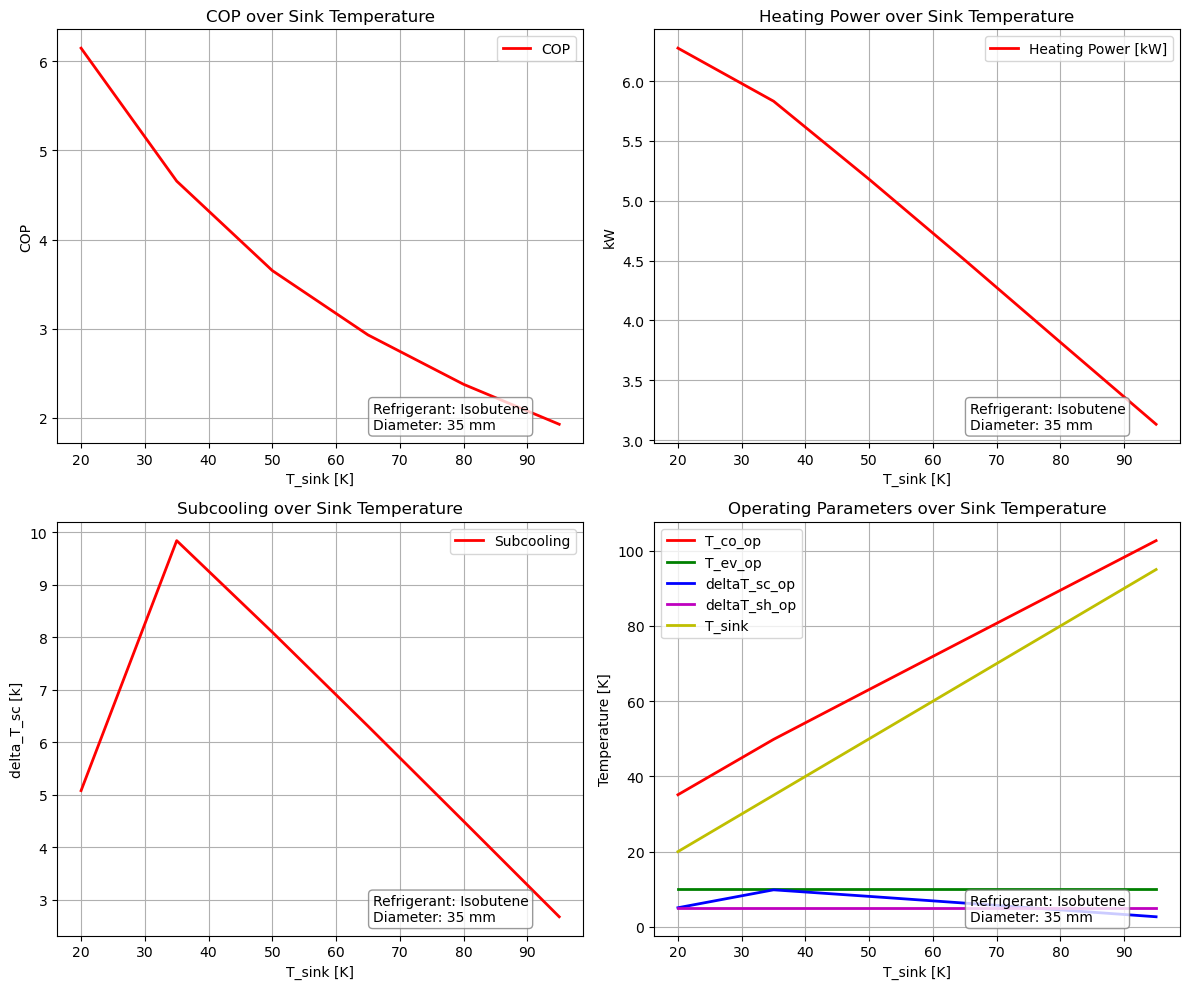

In [ ]:
j = 2 # refrigerant ['Isobutane', 'Butane', 'Isobutene', 'DimethylEther']
k = 0 # diameter 35, 40, 45, 50

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  # flatten to 1D array for easy indexing

info_text = f"Refrigerant: {refrigerants[j]}\nDiameter: {all_dia_comp[k]}"

# 1) COP over T_sink
axs[0].plot(T_water_sink, COP_HP[j, k, :], 'r-', linewidth=2, label='COP')
axs[0].set_ylabel('COP')
axs[0].set_xlabel('T_sink [K]')
axs[0].set_title('COP over Sink Temperature')
axs[0].legend()
axs[0].grid(True)

# 2) Heating power over T_sink
axs[1].plot(T_water_sink, Q_HP[j, k, :], 'r-', linewidth=2, label='Heating Power [kW]')
axs[1].set_ylabel('kW')
axs[1].set_xlabel('T_sink [K]')
axs[1].set_title('Heating Power over Sink Temperature')
axs[1].legend()
axs[1].grid(True)

# 3) Subcooling over T_sink (operating_param[..., 2])
axs[2].plot(T_water_sink, operating_param[j, k, :, 2], 'r-', linewidth=2, label='Subcooling')
axs[2].set_ylabel('delta_T_sc [k]')
axs[2].set_xlabel('T_sink [K]')
axs[2].set_title('Subcooling over Sink Temperature')

axs[2].legend()
axs[2].grid(True)

# 4) Multiple operating parameters over T_sink
colors = ['r', 'g', 'b', 'm', 'y']
labels = ['T_co_op', 'T_ev_op', 'deltaT_sc_op', 'deltaT_sh_op', 'T_sink']

for i in range(5):
    axs[3].plot(T_water_sink, operating_param[j, k, :, i], color=colors[i], linewidth=2, label=labels[i])

axs[3].set_xlabel('T_sink [K]')
axs[3].set_ylabel('Temperature [K]')

axs[3].set_title('Operating Parameters over Sink Temperature')

axs[3].legend()

axs[3].grid(True)

info_text = f"Refrigerant: {refrigerants[j]}\nDiameter: {all_dia_comp[k]} mm"

for i in range(4):
    axs[i].text(0.60, 0.1, info_text,
                transform=axs[i].transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8))

plt.tight_layout()
plt.show()

# Plotting heat pump parameters
In the folowing the heat pump cycle points of a selected configuration and sink temperature are plotted. 

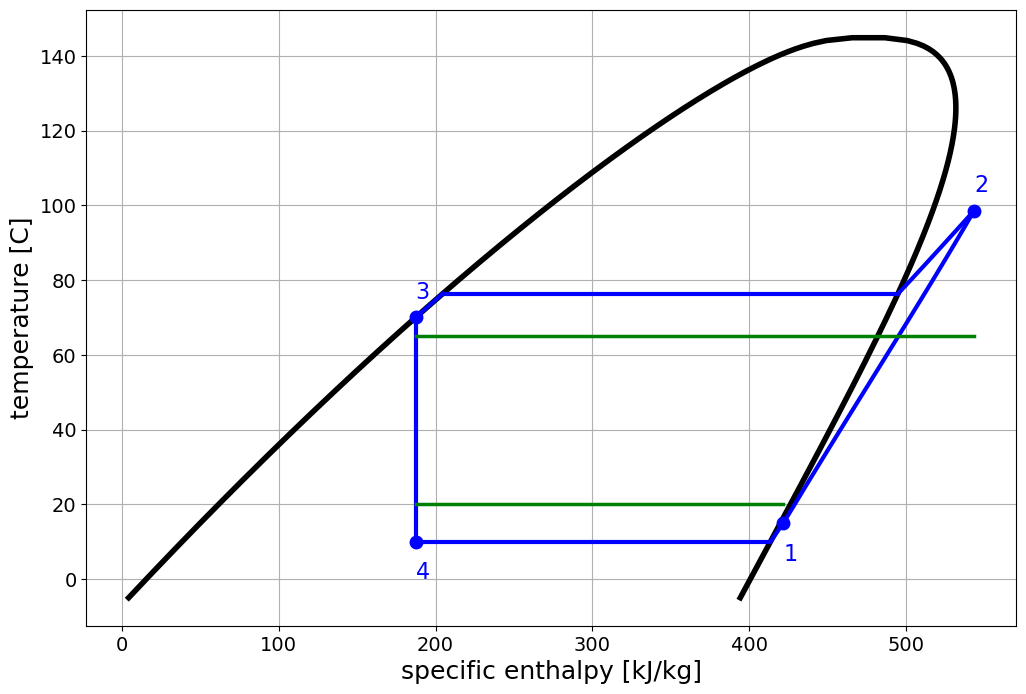

In [10]:
# plots a T-h diagram for a selected heat pump configuration for a specific sink temeprature. Serves as validation for the min_pinch and superheating/subcooling

j = 2 # refrigerant ['Isobutane', 'Butane', 'Isobutene', 'DimethylEther']
k = 0 # diameter 35, 40, 45, 50
T_si_index = 3 # 20, 35, 50, 65, 80, 95
fluid_diag = refrigerants[j]
dia_diag = all_dia_comp[k]

# Optimum by minimizer

T_co_op, T_ev_op, deltaT_sc_op, deltaT_sh_op, T_sink = operating_param[j, k, T_si_index]

state1_sat_new=FCP.state(["T","x"],[T_ev_op,1.0],fluid_diag,Eh)
if deltaT_sh_op>0.:
    state1_new=FCP.state(["T","p"],[T_ev_op+deltaT_sh_op,state1_sat_new["p"]],fluid_diag,Eh)
else:
    state1_new=state1_sat_new
state3_new = FCP.state(["T","x"],[T_co_op,0.0],fluid_diag,Eh)
state3_sc_new = FCP.state(["T","p"],[T_co_op - deltaT_sc_op,state3_new["p"]],fluid_diag,Eh)
            
param = [T_ev_op, T_co_op, deltaT_sh_op, deltaT_sc_op, dia_diag]
efficiency = CM.recip_comp_SP(param, fluid_diag)[0]
            
state2_is_new = FCP.state(["p","s"],[state3_sc_new["p"], state1_new["s"]],fluid_diag,Eh)
h_2 = (state2_is_new["h"] - state1_new["h"])/(efficiency) + state1_new["h"]
state2_new = FCP.state(["p","h"],[state3_sc_new["p"],h_2],fluid_diag,Eh)
state4_new = FCP.state(["p","h"],[state1_new["p"], state3_sc_new["h"]],fluid_diag,Eh)

# plots the operation points from the optimized parameters above

Diag.Th(state1_new,state2_new,state3_sc_new,state4_new,[T_sink,T_sink],[T_so,T_so],fluid_diag,Eh)

# Heat Pump Simulation
In this part of the code, the heat pump circuits are set up in a pasta cooker and simulated in a real usage scenario over 12 hours.

Task: Simulate the operation of the pasta cooker, including the heat pump process. Additionally simulate the operation of an electrically heated pasta cooker.

Approach: During the 12-hour simulation, all parameters such as heat output and COP are recorded in order to derive the relevant system properties.

Requirements: Consider Pasta Cookers thermal requirements, which are all implemented in the model_day function

In [ ]:
# parameters for the modeling of the pasta cooker

R_water_pasta = 15. # [K/kW]
R_air_water = 30. # [K/kW]
m_pasta = 0.5 # [kg] per batch
m_water = 25.38 # [kg] total
n_pasta = 4 # number of batches
c_pasta = 3.5 # [kJ/kgK]
c_water = 4.18 # [kJ/kgK]
T_air = 20 + 273 # [K]
# Model of usage
t0 = 0
tn = 12 * 60 * 60 #[s] (period of 12 hours) # 43200
n = tn + 1
t = np.linspace(t0, tn, n) # 0-43200
Q_dot_demand_min = 3.0 # kW

# All relevant operating parameters are recorded in these arrays for later evaluation

nb_on_off_HP = np.zeros((4,4))
time_heating_up_HP = np.zeros((4,4))
time_heating_up_min_HP = np.zeros((4,4)) 
time_on_HP = np.zeros((4,4))
Q_current_HP = np.zeros((4,4,n))
Q_average_HP = np.zeros((4,4))
Q_tot_HP = np.zeros((4,4))
W_current_HP = np.zeros((4,4,n))
W_tot_HP = np.zeros((4,4))
P_tot = np.zeros((4,4))
COP_current_HP = np.zeros((4,4,n))
COP_average_HP = np.zeros((4,4))
COP_tot_HP = np.zeros((4,4))
COP_degraded_HP = np.zeros((4,4))
COP_degraded_avg = np.zeros((4,4))
T_water_HP = np.zeros((4,4,n))
T_pasta_HP = np.zeros((4,4,n))

results_compare_HP = np.zeros((10,n))

#arrays find limit

nb_on_off_lim = np.zeros(3)
time_heating_up_lim = np.zeros(3)
time_HP_on_lim = np.zeros(3)
Q_current_lim = np.zeros((3,n))
Q_average_lim = np.zeros(3)
Q_tot_lim = np.zeros(3)
COP_current_lim = np.zeros((3,n))
COP_average_lim = np.zeros(3)
COP_degraded_lim = np.zeros(3)
T_water_lim = np.zeros((3,n))
T_pasta_lim = np.zeros((3,n))

results_compare_lim = np.zeros((10,n))

#arrays electric heater

nb_on_off_el = np.zeros(20)
time_heating_up_el = np.zeros(20)
time_HP_on_el = np.zeros(20)
Q_current_el = np.zeros((20,n))
Q_average_el = np.zeros(20)
Q_tot_el = np.zeros(20)
COP_current_el = np.zeros((20,n))
COP_average_el = np.zeros(20)
COP_degraded_el = np.zeros(20)
T_water_el = np.zeros((20,n))
T_pasta_el = np.zeros((20,n))

results_compare_el = np.zeros((10,n))

In [12]:
# Model of the pasta temperature

#energy balance of water: Q_HP - Q_pasta - Qloss

def model_pasta(T_pasta, t, T_water):

# Model Pasta --> Qin from heat transfer water-->pasta, Qloss: zero

    dT_pastadt = (1/R_water_pasta * (T_water - T_pasta)) / (n_pasta * m_pasta * c_pasta)

    return dT_pastadt

In [13]:
# Model of the water temperature

def model_water(T_water,t, T_pasta, Q_HP, pasta_in):

    if pasta_in == 1:
        dT_waterdt = (Q_HP - 1/R_air_water*(T_water - T_air) - 1 / R_water_pasta*(T_water - T_pasta)) / (m_water * c_water)
    else: 
        dT_waterdt = (Q_HP - 1/R_air_water*(T_water - T_air)) / (m_water * c_water)
    
    return dT_waterdt

# solve ODE

# Interpolation of Heat Pump Parameters
The get_power function interpolates the heat pump parameters such as COP, Q and W for each desired water temperature.

In [ ]:
def get_power(T_current, Q, W, COP):

    x_data = T_water_sink
    y_data_Q = Q # ref, dia, T_sink

    values= np.poly1d(np.polyfit(x_data,y_data_Q,1))

    current_Power = values(T_current-273)

    y_data_COP = COP

    values= np.poly1d(np.polyfit(x_data,y_data_COP,1))

    current_COP = values(T_current-273)

    z_data_W = W

    values = np.poly1d(np.polyfit(x_data,z_data_W,1))

    current_Comp_Power = values(T_current-273)

    return current_Power,current_COP, current_Comp_Power

# Simulation
In the model_day function, the pasta cooker is simulated in a real day operation.

In [15]:
# model of the use-case using if-conditions and the functions above for simulation

def model_day(Q,COP,W):
    break_on = 0
    pasta_in = 0
    break_timer = 0
    pasta_timer = 0
    heating_on = 1
    heating_up = 1


    T_water = (20+273) * np.ones(n)
    T_pasta = (7+273) * np.ones(n)

    time_heating  = 0
    nb_on_off = 0
    Q_tot = 0
    Q_current = np.zeros(n)
    W_current = np.zeros(n)
    COP_tot = 0
    COP_current = np.zeros(n)
    HP_on = np.zeros(n)
    COP_counter = 0
    COP_degraded = 0
    for i in range(tn):
      
        t_input = np.zeros(2)
        T_pasta_0 = T_pasta[i]
        T_water_0 = T_water[i]
    
        t_input[0] = t[i]
        t_input[1] = t[i+1]
    
        
        Q_in,COP_running, W_comp = get_power(T_water[i],Q, W, COP) # T_sink, ref, dia_comp
          
        if heating_up == 1:
    
            time_heating +=1
            
            T_water[i+1] = odeint(model_water,T_water_0,t_input,args=(T_pasta[i],Q_in,pasta_in,))[1][0]
    
            if T_water[i+1]>93 + 273:
                heating_up = 0
                pasta_in = 1
            HP_on[i] = 1
            
        else:
    
            if T_water[i] > 93. + 273:
                heating_on = 0
                nb_on_off +=1
            elif T_water[i] <86 + 273: # Should be possibly higher than 85°C to prevent a temperature drop when pasta is inserted
                heating_on = 1
                
            if heating_on == 0:
                Q_in = 0
                COP_running = 0
               
               
            if break_on == 1:
                T_water[i+1] = odeint(model_water,T_water_0,t_input,args=(T_pasta[i],Q_in,pasta_in,))[1][0]
                break_timer +=1
       
               
            else:
                T_pasta[i+1] = odeint(model_pasta,T_pasta_0,t_input,args=(T_water[i],))[1][0]
                T_water[i+1] = odeint(model_water,T_water_0,t_input,args=(T_pasta[i],Q_in,pasta_in,))[1][0]
                pasta_timer +=1
           
       
            if pasta_timer >= 420:
                break_on = 1
                pasta_in = 0
                pasta_timer = 0
             
            if break_timer >= 300:
                break_on = 0
                break_timer = 0
                pasta_in = 1

            if Q_in > 0:
                COP_degraded +=  COP_running * (Q_dot_demand_min/Q_in) / ((Q_dot_demand_min/Q_in) * 0.9 + 0.1)      
                COP_counter += 1
                HP_on[i] = 1
              
        Q_tot += Q_in
        Q_current[i] = Q_in
        W_current[i] = W_comp
        COP_tot += COP_running
        COP_current[i] = COP_running

    if nb_on_off <= 2:
        COP_degraded = COP_tot
    COP_degraded_avg = COP_degraded/COP_counter

    return T_water, T_pasta, Q_tot, Q_current, COP_tot, COP_current,COP_degraded_avg, nb_on_off, time_heating, COP_counter, W_current



The following for-loop iterates iterates through various configurations, calling the simulation function for each and storing the results.

In [ ]:
for j,fluid in enumerate(refrigerants):
    for k,dia_comp in enumerate(all_dia_comp):
        
        results_compare_HP = model_day(Q_HP[j,k,:],COP_HP[j,k,:],W_HP[j,k,:])
        time_on_HP[j,k] = results_compare_HP[9]

        COP_tot_HP[j,k] = results_compare_HP[4]
        time_heating_up_HP[j,k] = results_compare_HP[8]
        Q_tot_HP[j,k] = results_compare_HP[2]
        COP_degraded_avg[j,k] = results_compare_HP[6]
        nb_on_off_HP[j,k] = results_compare_HP[7]
        T_water_HP[j,k,:]= results_compare_HP[0]
        T_pasta_HP[j,k,:]= results_compare_HP[1]
        Q_current_HP[j,k,:]= results_compare_HP[3]
        W_current_HP[j,k,:]= results_compare_HP[10]
        
Q_average_HP = Q_tot_HP/time_on_HP

COP_average_HP = COP_tot_HP/time_on_HP       

P_tot_HP = np.sum(W_current_HP, axis=2) / 3600
        
time_heating_up_min_HP = time_heating_up_HP/60


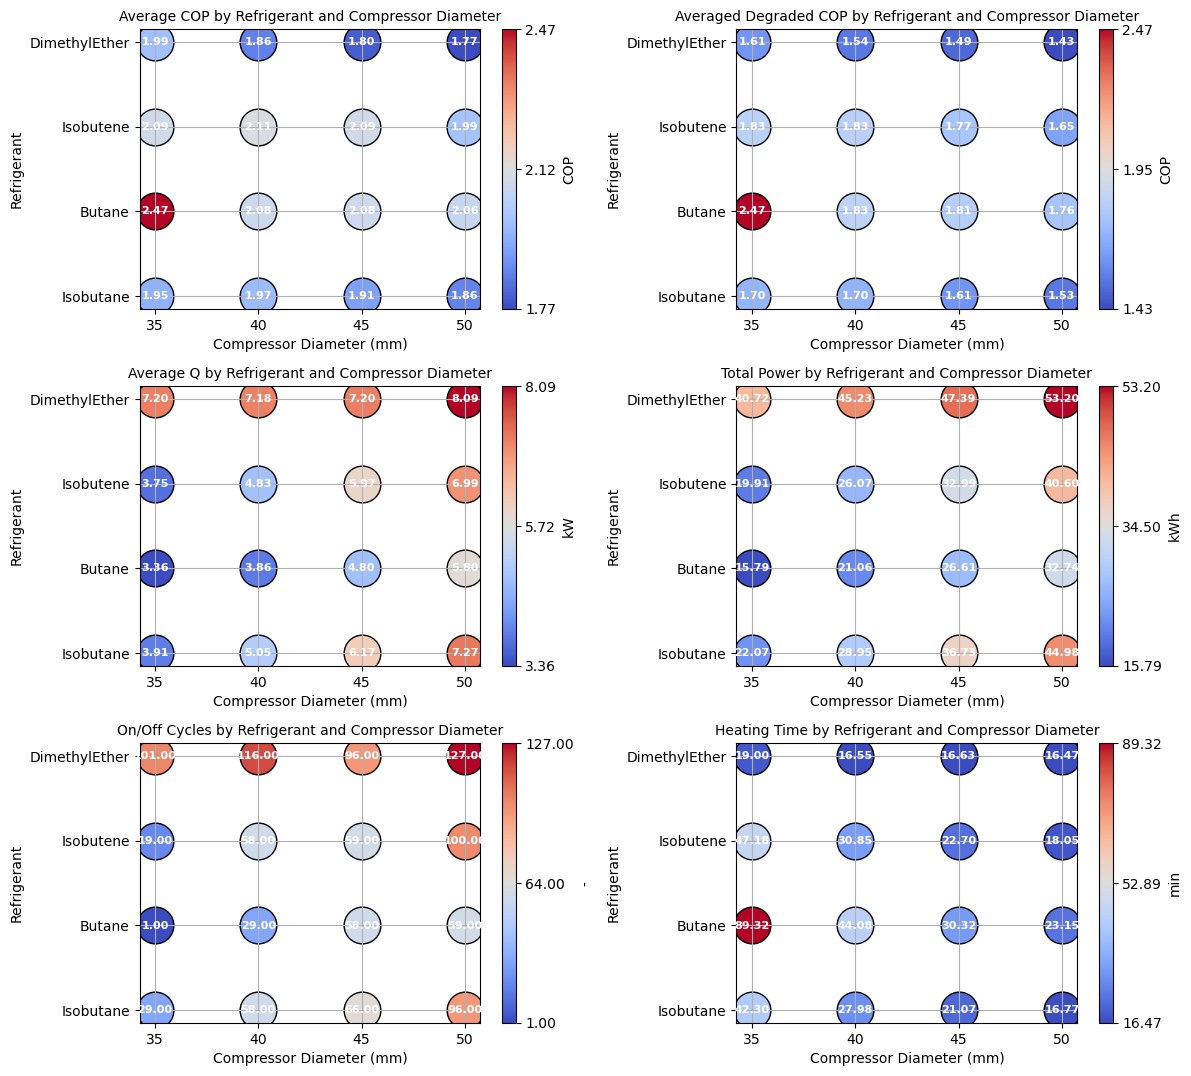

In [ ]:
# Comparison of heat pump process parameters between all configurations.
metrics = [
    ("Average COP", COP_average_HP, "COP", "Average COP by Refrigerant and Compressor Diameter"),
    ("Averaged Degraded COP", COP_degraded_avg, "COP", "Averaged Degraded COP by Refrigerant and Compressor Diameter"),
    ("Average Q", Q_average_HP, "kW", "Average Q by Refrigerant and Compressor Diameter"),
    ("Total Power", P_tot_HP, "kWh", "Total Power by Refrigerant and Compressor Diameter"),
    ("On/Off Cycles", nb_on_off_HP, "-", "On/Off Cycles by Refrigerant and Compressor Diameter"),
    ("Heating Up Time", time_heating_up_min_HP, "min", "Heating Time by Refrigerant and Compressor Diameter"),
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
axes = axes.flatten()

for idx, (label, data, unit, title) in enumerate(metrics):
    ax = axes[idx]

    for i, ref in enumerate(refrigerants):
        for j, dia in enumerate(all_dia_comp):
            value = data[i, j]
            scatter = ax.scatter(
                dia, i, c=value, cmap='coolwarm', s=700, edgecolors='black',
                vmin=np.min(data), vmax=np.max(data)
            )
            ax.text(dia, i, f"{value:.2f}", ha='center', va='center', fontweight='semibold', color='white', fontsize=8)
    ax.set_yticks(np.arange(len(refrigerants)))
    ax.set_yticklabels(refrigerants)
    ax.set_xticks(all_dia_comp)
    ax.set_xlabel("Compressor Diameter (mm)")
    ax.set_ylabel("Refrigerant")
    ax.set_title(title, fontsize=10)

    # Farblegende hinzufügen
    sc = ax.scatter([], [], c=[], cmap='coolwarm', vmin=np.min(data), vmax=np.max(data))
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(unit)

    vmin = np.min(data)
    vmax = np.max(data)
    vmid = (vmin + vmax) / 2

    cbar.set_ticks([vmin, vmid, vmax])
    cbar.set_ticklabels([f'{vmin:.2f}', f'{vmid:.2f}', f'{vmax:.2f}'])

    ax.grid(True)

# Leere Subplots ausblenden (falls weniger Metriken als Subplots)
if len(metrics) < len(axes):
    for idx in range(len(metrics), len(axes)):
        fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


# Temperature Profile
In the following, a specific configuration is selected and the water and pasta temperature as well as heat conduction are plotted. The “best” configuration depends on the requirements and desired benefits. In our work, we have chosen Isobutene-35 as the best configuration because it has the lowest power consumption in operation after Butane-35 and an acceptable warm-up time.

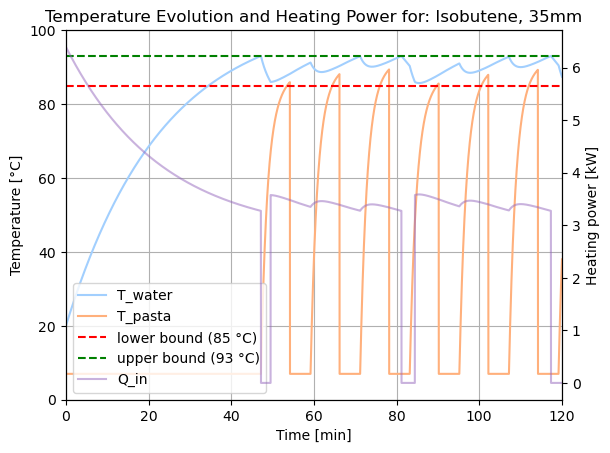

In [ ]:
j_selected = 2 # refrigerant ['Isobutane', 'Butane', 'Isobutene', 'DimethylEther']
k_selected = 0 # Durchmesser 35, 40, 45, 50

fig, ax1 = plt.subplots()

# Linke Achse: Temperaturverläufe
#ax1.plot(t, T_water_Plot[q] - 273, label="Wassertemperatur 2.8kW", color='tab:blue')
ax1.plot(t/60, T_water_HP[j_selected,k_selected,:] - 273, label="T_water", color='#A2CFFE')
ax1.plot(t/60, T_pasta_HP[j_selected,k_selected,:] - 273, label="T_pasta", color='#FFB07C')
#ax1.plot(t/60, T_water_Plot[3] - 273, label="Wassertemperatur 3.4kW", color='#B5EAD7')

ax1.axhline(y=85, color='red', linestyle='--' , label='lower bound (85 °C)')
ax1.axhline(y=93, color='green', linestyle='--' , label='upper bound (93 °C)')
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Temperature [°C]")
ax1.set_xlim(0, 2*60)
ax1.set_ylim(0,100)
ax1.grid(True)

# Rechte Achse: Leistung Q_in
ax2 = ax1.twinx()
ax2.plot(t/60, Q_current_HP[j_selected,k_selected,:], label="Q_in", color='tab:purple', alpha=0.5)
ax2.set_ylabel("Heating power [kW]")

# Legenden zusammenführen
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')

plt.title(f"Temperature Evolution and Heating Power for: {refrigerants[j_selected]}, {all_dia_comp[k_selected]}mm")
plt.show()

#T_water_min  = T_water_HP[:,:,10000:].min() -273
#print("Lowest water temperature of any configuration", T_water_min)

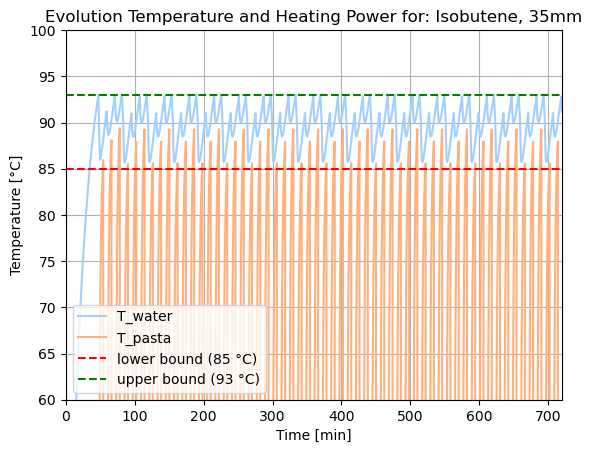

In [ ]:
# 12-hour Temperature Profile

#j = 2 # -->Butane
#k = 0 # -->40mm

fig, ax1 = plt.subplots()

# Linke Achse: Temperaturverläufe
#ax1.plot(t, T_water_Plot[q] - 273, label="Wassertemperatur 2.8kW", color='tab:blue')
ax1.plot(t/60, T_water_HP[j_selected,k_selected,:] - 273, label="T_water", color='#A2CFFE')
ax1.plot(t/60, T_pasta_HP[j_selected,k_selected,:] - 273, label="T_pasta", color='#FFB07C')
#ax1.plot(t/60, T_water_Plot[3] - 273, label="Wassertemperatur 3.4kW", color='#B5EAD7')

ax1.axhline(y=85, color='red', linestyle='--' , label='lower bound (85 °C)')
ax1.axhline(y=93, color='green', linestyle='--' , label='upper bound (93 °C)')
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Temperature [°C]")
ax1.set_xlim(0, 12*60)
ax1.set_ylim(60,100)
ax1.grid(True)

# Rechte Achse: Leistung Q_in
#ax2 = ax1.twinx()
#ax2.plot(t/60, results_compare_HP[3], label="Q_in", color='tab:purple', alpha=0.5)
#ax2.set_ylabel("Heating power [kW]")

# Legenden zusammenführen
lines_1, labels_1 = ax1.get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='lower left')

plt.title(f"Evolution Temperature and Heating Power for: {refrigerants[j_selected]}, {all_dia_comp[k_selected]}mm")
plt.show()

In [20]:
#optimize for heating power electric heater!!!

# internet: 3.5kW/7l
# 7.8kW/24l
#https://cdn.chrombox.ch/media/1c/aa/93/1660141207/mashka_valentine_brochure_pastakocher_de.pdf
#25-40l: 6.6kW - 10kW
#20l: 4.5kW

# Electric Heater

Task: 1: Simulate a pasta cooker with an electric heater to determine the minimal heating power
      2: Record the benchmarks of an 8kW pasta cooker to compare it with the heat pump-powered ones.

Approach: 12-hour Simulation with the model_day function

Requirements: Consider Pasta Cookers thermal requirements

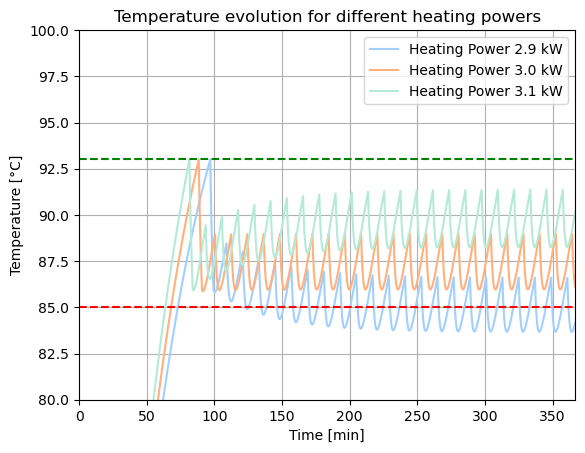

In [21]:
#Conditions/Parameters System Modelling

nbOpt = 3 # -> step is 0.1kW
Q_el_tot = np.linspace(2.9,3.1,nbOpt)

for q,Q_el in enumerate(Q_el_tot):

    Q = Q_el*np.ones(6)
    COP = np.ones(6)
    W = np.zeros(6)
    results_compare_lim = model_day(Q,COP,W)
    T_water_lim[q] = results_compare_lim[0]

#q = 0 # 2.0, 2.5, ..., 6.0

fig, ax1 = plt.subplots()


# Linke Achse: Temperaturverläufe
#ax1.plot(t, T_water_Plot[q] - 273, label="Wassertemperatur 2.8kW", color='tab:blue')
ax1.plot(t/60, T_water_lim[0] - 273, label="Heating Power 2.9 kW", color='#A2CFFE')
ax1.plot(t/60, T_water_lim[1] - 273, label="Heating Power 3.0 kW", color='#FFB07C')
ax1.plot(t/60, T_water_lim[2] - 273, label="Heating Power 3.1 kW", color='#B5EAD7')


ax1.axhline(y=85, color='red', linestyle='--') #, label='85 °C')
ax1.axhline(y=93, color='green', linestyle='--') #, label='93 °C')
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Temperature [°C]")
ax1.set_xlim(0, 22000/60)
ax1.set_ylim(80,100)
ax1.grid(True)

# Rechte Achse: Leistung Q_in
#ax2 = ax1.twinx()
#ax2.plot(t, Q_in_Plot[q], label="Q_in", color='tab:purple', alpha=0.5)
#ax2.set_ylabel("Leistung [kW]")

# Legenden zusammenführen
lines_1, labels_1 = ax1.get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
#ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')
ax1.legend(lines_1, labels_1)

plt.title("Temperature evolution for different heating powers")
plt.show()

# While an electric heater with 3.0kW power does not privide enough power to keep the water at
# temperature, the one with 3.4kW undergoes on/off switching. Therefore the heater with 3.2kW
# is selected to set the q_demand for COP calculation

Q_dot_demand_min = 3.0 #kW, derived from observation above

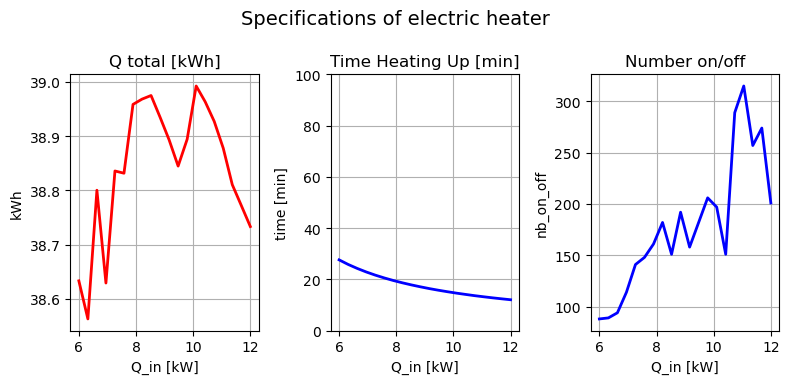

In [22]:
#electric heater 6,8,10,12 kW

nbConfig = 20
Q_el_tot = np.linspace(6,12,nbConfig)

for q,Q_el in enumerate(Q_el_tot):

    Q = Q_el*np.ones(6)
    COP = np.ones(6)
    W = np.zeros(6)
    
    results_compare_el = model_day(Q,COP,W)
    nb_on_off_el[q] = results_compare_el[7]
    Q_tot_el[q] = results_compare_el[2]
    time_heating_up_el[q] = results_compare_el[8]

fig, axs = plt.subplots(1, 3, sharex=False, figsize=(8, 4))

# Plot 1: Q_total
axs[0].plot(Q_el_tot, Q_tot_el/3600, 'r-', linewidth=2)
axs[0].set_xlabel('Q_in [kW]')
axs[0].set_ylabel('kWh')
axs[0].set_title('Q total [kWh]')
axs[0].grid(True)

# Plot 2: t_heating_up
axs[1].plot(Q_el_tot, time_heating_up_el/60, 'b-', linewidth=2)
axs[1].set_xlabel('Q_in [kW]')
axs[1].set_ylabel('time [min]')
axs[1].set_title('Time Heating Up [min]')
axs[1].set_ylim(0, 100)
axs[1].grid(True)

# Plot 3: t_heating_up
axs[2].plot(Q_el_tot, nb_on_off_el, 'b-', linewidth=2)
axs[2].set_xlabel('Q_in [kW]')
axs[2].set_ylabel('nb_on_off')
axs[2].set_title('Number on/off')
#axs[2].set_ylim(0, 100)
axs[2].grid(True)

fig.suptitle('Specifications of electric heater', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

# Isobutene 35-50
Side-by-side diagrams of the heat pump driven pasta cooker with isobutene and different piston diameters.

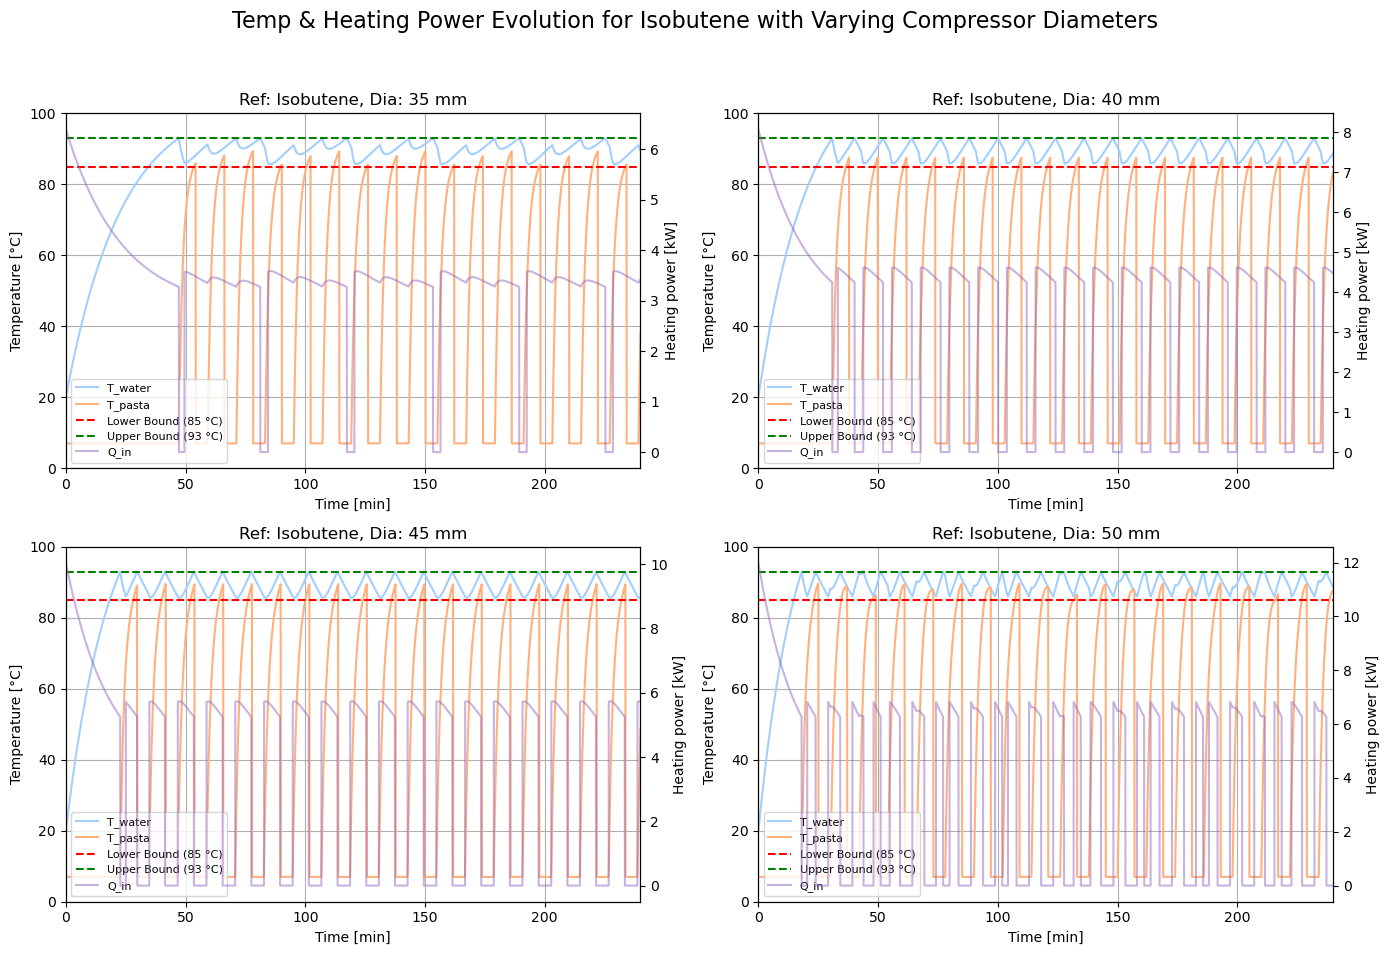

In [54]:
# --- Set refrigerant index and name
j = 2  # Isobutene

# --- Create 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for k in range(4):  # Loop over diameter indices
    ax1 = axs[k]
    ax2 = ax1.twinx()

    # Plot water and pasta temperatures
    ax1.plot(t / 60, T_water_HP[j, k, :] - 273, label="T_water", color='#A2CFFE')
    ax1.plot(t / 60, T_pasta_HP[j, k, :] - 273, label="T_pasta", color='#FFB07C')

    # Temperature thresholds
    ax1.axhline(y=85, color='red', linestyle='--', label='Lower Bound (85 °C)')
    ax1.axhline(y=93, color='green', linestyle='--', label='Upper Bound (93 °C)')

    ax1.set_xlim(0, 4 * 60)
    ax1.set_ylim(0, 100)
    ax1.set_xlabel("Time [min]")
    ax1.set_ylabel("Temperature [°C]")
    ax1.grid(True)

    # Plot heating power
    ax2.plot(t / 60, Q_current_HP[j, k, :], label="Q_in", color='tab:purple', alpha=0.5)
    ax2.set_ylabel("Heating power [kW]")

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=8, loc='lower left')

    # Subplot title
    ax1.set_title(f"Ref: {refrigerants[j]}, Dia: {all_dia_comp[k]} mm")

# Global figure title
fig.suptitle(f"Temp & Heating Power Evolution for {refrigerants[j]} with Varying Compressor Diameters", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Heat Pump Performance Analysis
In this part of the code, we select the operation parameters of the Isobutene-35 heat pump and compare it to the electric one with 8kW.

Task: Calculate the energy savings, electricity savings and CO2 emissions reduction.

Requirements: Use Zurich´s electricity cost and emission factor.

Approach: Calculation of the savings compared to the electrical heater and comparison of the heat up time.

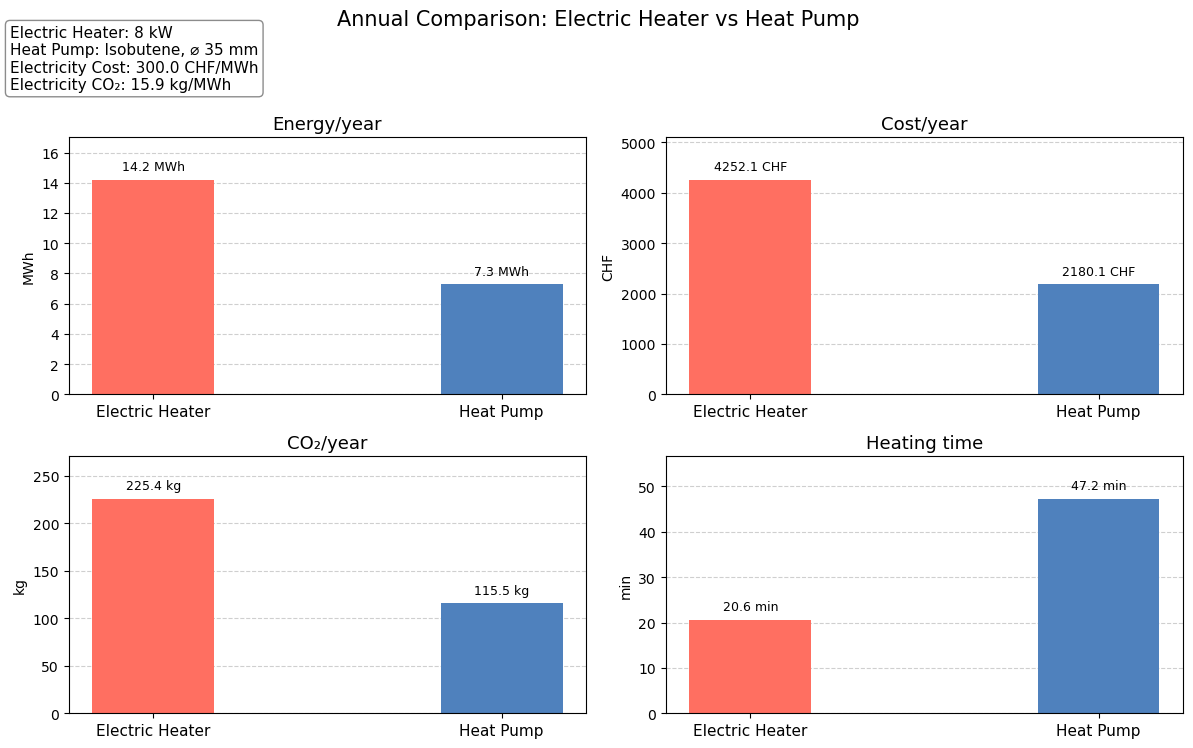

In [58]:
#isobutene with 35mm diameter
#electric heater with 8kW

#j = 2 # refrigerant ['Isobutane', 'Butane', 'Isobutene', 'DimethylEther']
#k = 0 # Durchmesser 35, 40, 45, 50


# --- Constants
cost_el_zurich = 0.3 * 1000  # CHF/MWh
co2_el_zurich = 0.0159 * 1000    # kg/MWh

# --- Extract values from simulation
energy_year_el = Q_tot_el[5] / 3600 * 365 / 1000
energy_year_hp = P_tot_HP[j_selected, k_selected] * 365 / 1000

cost_year_el = energy_year_el * cost_el_zurich
cost_year_hp = energy_year_hp * cost_el_zurich

co2_year_el = energy_year_el * co2_el_zurich
co2_year_hp = energy_year_hp * co2_el_zurich

heating_time_el = time_heating_up_el[5] / 60
heating_time_hp = time_heating_up_min_HP[j_selected, k_selected]

# --- Data for plotting
categories = ['Energy/year', 'Cost/year', 'CO₂/year', 'Heating time']
el_heater = [energy_year_el, cost_year_el, co2_year_el, heating_time_el]
hp = [energy_year_hp, cost_year_hp, co2_year_hp, heating_time_hp]
units = ['MWh', 'CHF', 'kg', 'min']

labels = ['Electric Heater', 'Heat Pump']
x = np.arange(2)
bar_width = 0.35

# --- Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

colors = ['#FF6F61', '#4F81BD']  # Heater: red, HP: blue

for i, ax in enumerate(axs):
    # Side-by-side bars
    bar_positions = x
    values = [el_heater[i], hp[i]]
    bars = ax.bar(bar_positions, values, bar_width, color=colors, label=labels)

    # Y-axis label and title
    ax.set_title(categories[i], fontsize=13)
    ax.set_ylabel(units[i])
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(labels, fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)

    # Adjust y-limit for space above bar
    max_val = max(values)
    ax.set_ylim(0, max_val * 1.2)

    # Annotate each bar with value
    for bar, value in zip(bars, values):
        ax.annotate(f'{value:.1f} {units[i]}',
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# --- Info box content
el_power_kw = 8

info_text = (
    f"Electric Heater: {el_power_kw} kW\n"
    f"Heat Pump: {refrigerants[j_selected]}, ⌀ {all_dia_comp[k_selected]} mm\n"
    f"Electricity Cost: {cost_el_zurich:.1f} CHF/MWh\n"
    f"Electricity CO₂: {co2_el_zurich:.1f} kg/MWh"
)

# --- Add info box above all plots
fig.text(0.01, 0.96, info_text,
         fontsize=11,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.9))

# --- Final layout
fig.suptitle('Annual Comparison: Electric Heater vs Heat Pump', fontsize=15)
plt.tight_layout(rect=[0, 0.05, 1, 0.91])  # Adjust to make space for title & info box
plt.show()